THis notebook helps you analyze which qubit network connectivity is chosen as a function of time. 

In [1]:
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '..')
# for saving
import os
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from src import setup
# setup.use_gpu()

In [2]:
from src import ( 
    measurements as measure,
    density_matrix as DM,
    simulation as sim,
    orders,
    order_rules,
    random_unitary,
    simulation)
from Scripts import simulation_CLI as cleo

In [3]:
import matplotlib.animation as animation
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '../..')
import h5py
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from src import ket as ket
from src import density_matrix as DM
from collections import Counter
import matplotlib.cm as cm
from scipy.optimize import curve_fit
import sys as SYS; SYS.path.insert(0, '../..')
from Scripts import hdf5merge
import matplotlib.colors as mcolors

In [4]:
#hdf5merge.merge_hdf5_files("../data/random")
#hdf5merge.merge_hdf5_files("../data/greedy")
hdf5merge.merge_hdf5_files("../data/mimic_12_disorder")
#hdf5merge.merge_hdf5_files("../data/landscape_maximizes")
#hdf5merge.merge_hdf5_files("../data/strongest_maximizes")

In [4]:
newdata1_th = dict(h5py.File("../data/unnati_submit_12_therm_random/unnati_submit_12_therm_random.hdf5"))
newdata2_th = dict(h5py.File("../data/unnati_submit_12_therm_greedy/unnati_submit_12_therm_greedy.hdf5"))
newdata3_th = dict(h5py.File("../data/unnati_submit_12_therm_mimic/unnati_submit_12_therm_mimic.hdf5"))
newdata4_th = dict(h5py.File("../data/unnati_submit_12_therm_landmax/unnati_submit_12_therm_landmax.hdf5"))
newdata5_th = dict(h5py.File("../data/unnati_submit_12_therm_strong_max/unnati_submit_12_therm_strong_max.hdf5"))

newdata1_pure = dict(h5py.File("../data/unnati_submit_12_pure_random/unnati_submit_12_pure_random.hdf5"))
newdata2_pure = dict(h5py.File("../data/unnati_submit_12_pure_greedy/unnati_submit_12_pure_greedy.hdf5"))
newdata3_pure = dict(h5py.File("../data/unnati_submit_12_pure_mimic/unnati_submit_12_pure_mimic.hdf5"))
newdata4_pure = dict(h5py.File("../data/unnati_submit_12_pure_landmax/unnati_submit_12_pure_landmax.hdf5"))
newdata5_pure = dict(h5py.File("../data/unnati_submit_12_pure_strongmax/unnati_submit_12_pure_strongmax.hdf5"))

newdata1_v1 = dict(h5py.File("../data/unnati_submit_12_inhomo_v1_random/unnati_submit_12_inhomo_v1_random.hdf5"))
newdata2_v1 = dict(h5py.File("../data/unnati_submit_12_inhomo_v1_greedy/unnati_submit_12_inhomo_v1_greedy.hdf5"))
newdata3_v1 = dict(h5py.File("../data/unnati_submit_12_inhomo_v1_mimic/unnati_submit_12_inhomo_v1_mimic.hdf5"))
newdata4_v1 = dict(h5py.File("../data/unnati_submit_12_inhomo_v1_landmax/unnati_submit_12_inhomo_v1_landmax.hdf5"))
newdata5_v1 = dict(h5py.File("../data/unnati_submit_12_inhomo_v1_strong_max/unnati_submit_12_inhomo_v1_strong_max.hdf5"))

newdata1_v2 = dict(h5py.File("../data/unnati_submit_12_inhomo_v2_random/unnati_submit_12_inhomo_v2_random.hdf5"))
newdata2_v2 = dict(h5py.File("../data/unnati_submit_12_inhomo_v2_greedy/unnati_submit_12_inhomo_v2_greedy.hdf5"))
newdata3_v2 = dict(h5py.File("../data/unnati_submit_12_inhomo_v2_mimic/unnati_submit_12_inhomo_v2_mimic.hdf5"))
newdata4_v2 = dict(h5py.File("../data/unnati_submit_12_inhomo_v2_landmax/unnati_submit_12_inhomo_v2_landmax.hdf5"))
newdata5_v2 = dict(h5py.File("../data/unnati_submit_12_inhomo_v2_strongmax/unnati_submit_12_inhomo_v2_strongmax.hdf5"))


In [5]:
#newdata1 = dict(h5py.File("../data/random/random.hdf5"))
#newdata2 = dict(h5py.File("../data/greedy/greedy.hdf5"))
newdata3 = dict(h5py.File("../data/mimic_12_disorder/mimic_12_disorder.hdf5"))
#newdata4 = dict(h5py.File("../data/landscape_maximizes/landscape_maximizes.hdf5"))
#newdata5 = dict(h5py.File("../data/strongest_maximizes/strongest_maximizes.hdf5"))

In [4]:
def get_pops(data, n_qubits, connectivity,update_rule):
    #dimension 0 is each trial
    #dimension 1 is each time step
    #dimension 2 is each qubit
    result = []
    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['pops'])
        dat = {int(k.split('(')[0]): dat[k] for k in dat}
        dat = np.array([np.array([dat[k][subkey][()] for subkey in sorted(dat[k])]) for k in sorted(dat)])
        result.append(dat)
    return(np.array(result))

def get_2_qbit_dms(data, n_qubits, connectivity,update_rule):
    basis = ket.canonical_basis(2)
    #dimension 0 is each trial
    #dimension 1 is each time step (recall that sampling step is 5 by default)
    #dimension 2 is qubit pair
    #dimension 3 and 4 is the 2 qubit density matrix
    result = []
    
    def to_tuple(string):
        tuple_elements = string.strip('()').split(',')
        return tuple(int(elem.strip()) for elem in tuple_elements)

    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['two_qubit_dms'])
        dat = {int(k.split('(')[0]): dat[k] for k in dat}
        
        dat = np.array([{to_tuple(subkey):DM.DensityMatrix(dat[k][subkey],basis) for subkey in sorted(dat[k])} for k in sorted(dat)])
        result.append(dat)
    return(np.array(result))

In [6]:
num=12

In [ ]:
pops_random_c2 = get_pops(newdata1, num, "c2_2local", "random")
pops_random_c4 = get_pops(newdata1, num, "c4_2local", "random")

In [ ]:
pops_greedy_c2 = get_pops(newdata2, num, "c2_2local", "greedy")
pops_greedy_c4 = get_pops(newdata2, num, "c4_2local", "greedy")

In [ ]:
pops_mimic_c2 = get_pops(newdata3, num, "c2_2local", "mimic")
pops_mimic_c4 = get_pops(newdata3, num, "c4_2local", "mimic")

In [54]:
pops_mimic_c2_2 = get_pops(newdata3_2, num, "c2_2local", "mimic")


In [10]:
pops_mimic_c2 = get_pops(newdata3, num, "c2_2local", "disorder_mimic")
#pops_mimic_c4 = get_pops(newdata3, num, "c4_2local", "mimic_12_disorder")

In [ ]:
pops_landscape_maximizes_c2 = get_pops(newdata4, num, "c2_2local", "landscape_maximizes")
pops_landscape_maximizes_c4 = get_pops(newdata4, num, "c4_2local", "landscape_maximizes")

In [ ]:
pops_strongest_maximizes_c2 = get_pops(newdata5, num, "c2_2local", "strongest_maximizes")
pops_strongest_maximizes_c4 = get_pops(newdata5, num, "c4_2local", "strongest_maximizes")

In [ ]:
twoQdmsrandomc2 = get_2_qbit_dms(newdata1,size,"c2_2local","random")
twoQdmsrandomc4 = get_2_qbit_dms(newdata1,size,"c4_2local","random")

In [ ]:
twoQdmslandscape_maxc2 = get_2_qbit_dms(newdata4,size,"c2_2local","landscape_maximizes")
twoQdmslandscape_maxc4 = get_2_qbit_dms(newdata4,size,"c4_2local","landscape_maximizes")

In [55]:
twoQdmsmimicc2_2 = get_2_qbit_dms(newdata3_2,num,"c2_2local","mimic")


In [11]:
twoQdmsmimicc2 = get_2_qbit_dms(newdata3,num,"c2_2local","disorder_mimic")
#twoQdmsmimicc4 = get_2_qbit_dms(newdata3,size,"c4_2local","mimic")

In [ ]:
twoQdmsstrongest_maxc2 = get_2_qbit_dms(newdata5,size,"c2_2local","strongest_maximizes")
twoQdmsstrongest_maxc4 = get_2_qbit_dms(newdata5,size,"c4_2local","strongest_maximizes")

In [33]:
import h5py
def load_orders_list(file_path: str, num_qubits, connectivity, unitary_energy_subspace, unitary_seed, order_rule_name: str):
    # Create an empty dictionary to hold orders_list
    orders_list = []

    with h5py.File(file_path, 'r') as file:
        # Construct the path to the specific group where orders_list is stored
        group_name = f"{num_qubits} qubits/{connectivity} connectivity/unitary energy subspace {unitary_energy_subspace}/unitary seed {unitary_seed}/ordering seed {order_rule_name}/previous_order"
        
        # Check if the group exists
        if group_name in file:
            group = file[group_name]
            for time_index in group:
                # Assuming the order data is stored in a dataset named 'data'
                orders_list.append(group[time_index]['data'][()])
        else:
            print(f"Group '{group_name}' not found in file.")
    
    return orders_list
outputs_c4_cs1_R1[0][12]

array([[ 0,  1],
       [ 4,  6],
       [ 8, 10],
       [ 5,  7],
       [ 2,  3],
       [ 9, 11]])

In [37]:
#code to generate how many time a particular neighbourhood shows up
from collections import defaultdict
occurrences = defaultdict(int)

# Loop through thenp.array and count each neighbourhood's occurrence
def dictionary_of_neighbourhoods(array_of_arrays_of_arrays):
    fornp.array innp.array_of_arrays_of_arrays:
        for subarray innp.array:
        # Convert each list (subarray) to a tuple (to make it hashable)
            tuple_subarray = tuple(map(tuple, subarray))  # Convert list of lists to tuple of tuples
            occurrences[tuple_subarray] += 1

# Print the occurrences of each neighbourhood
    dictionary = []
    for key, value in occurrences.items():
        dictionary.append([key, value])
    return dictionary

# Function to get all distinct neighbourhoods
def get_distinct_neighbourhoods(data):
    distinct_neighbourhoods = []
    for neighbourhood in data:
        # Check if the neighbourhood is already in the list of distinct neighbourhoods
        if not any(np.array_equal(neighbourhood, existing_neighbourhood) for existing_neighbourhood in distinct_neighbourhoods):
            distinct_neighbourhoods.append(neighbourhood)
    return distinct_neighbourhoods


# Function to track when each neighbourhood appears
def find_neighbourhood_appearances(data, distinct_neighbourhoods):
    time_steps = []
    for t, neighbourhood in enumerate(data):
        for i, distinct_neighbourhood in enumerate(distinct_neighbourhoods):
            if np.array_equal(neighbourhood, distinct_neighbourhood):
                time_steps.append((t + 1, f'{chr(97 + i)}'))  # Assign a label a, b, c, ...
    return time_steps
get_distinct_neighbourhoods(outputs_c4_cs1_R1[0])

[array([[11,  0],
        [ 3,  8],
        [10,  5],
        [ 9,  6],
        [ 2,  4],
        [ 7,  1]]),
 array([[ 8, 10],
        [ 6,  7],
        [ 4,  5],
        [ 0,  2],
        [ 9, 11],
        [ 1,  3]]),
 array([[ 0, 10],
        [ 1, 11],
        [ 6,  8],
        [ 2,  3],
        [ 7,  9],
        [ 4,  5]]),
 array([[ 0,  1],
        [10, 11],
        [ 6,  8],
        [ 2,  3],
        [ 7,  9],
        [ 4,  5]]),
 array([[ 1,  2],
        [ 0, 10],
        [ 4,  6],
        [ 9, 11],
        [ 3,  5],
        [ 7,  8]]),
 array([[ 2,  4],
        [ 0, 10],
        [ 1, 11],
        [ 6,  8],
        [ 7,  9],
        [ 3,  5]]),
 array([[ 1,  2],
        [ 0, 10],
        [ 3,  4],
        [ 6,  8],
        [ 5,  7],
        [ 9, 11]]),
 array([[ 2,  4],
        [ 8, 10],
        [ 7,  9],
        [ 5,  6],
        [ 1,  3],
        [ 0, 11]]),
 array([[ 0,  1],
        [ 2,  4],
        [ 8, 10],
        [ 6,  7],
        [ 9, 11],
        [ 3,  5]]),
 array([[ 

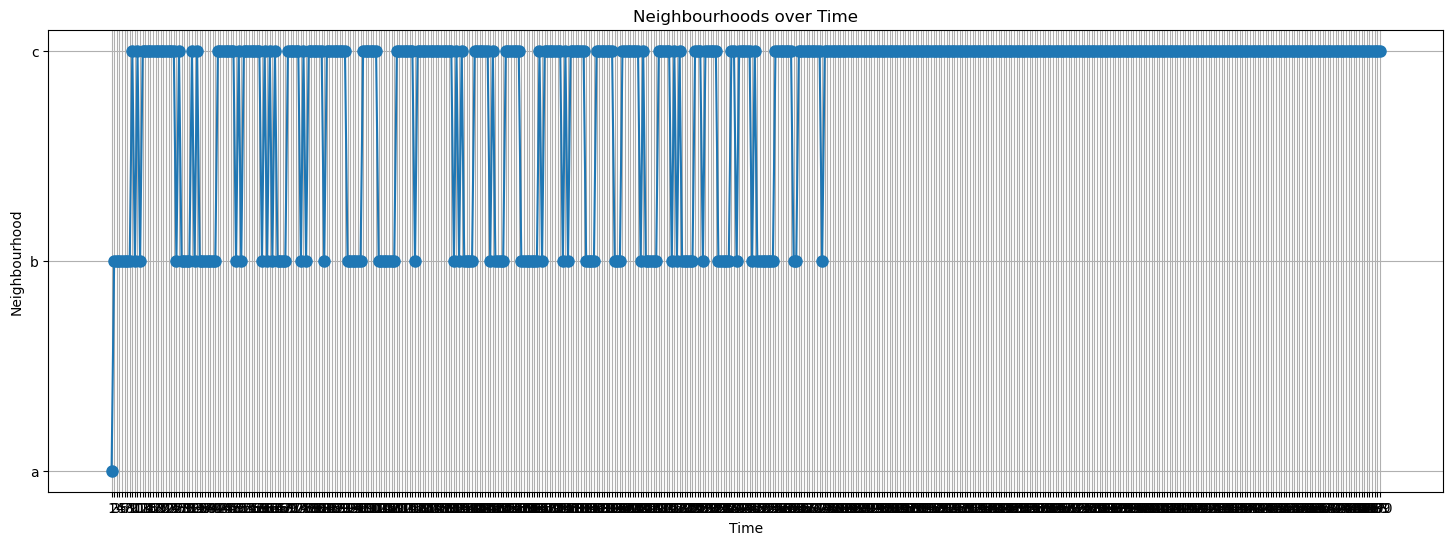

Distinct Neighbourhoods:
a: [[ 3 10]
 [11  7]
 [ 4  2]
 [ 0  6]
 [ 9  5]
 [ 1  8]]
b: [[ 0  1]
 [10 11]
 [ 2  3]
 [ 6  7]
 [ 4  5]
 [ 8  9]]
c: [[ 9 10]
 [ 1  2]
 [ 3  4]
 [ 0 11]
 [ 5  6]
 [ 7  8]]


In [213]:
data=outputs_R2_c2[8][0:499]
# Get the distinct neighbourhoods
distinct_neighbourhoods = get_distinct_neighbourhoods(data)

# Track when each neighbourhood appears
time_steps = find_neighbourhood_appearances(data, distinct_neighbourhoods)

# Separate out the time and labels for plotting
times = [t for t, label in time_steps]
labels = [label for t, label in time_steps]

# Plotting
plt.figure(figsize=(18, 6))
plt.plot(times, labels, marker='o', linestyle='-', markersize=8)

# Customize the plot
plt.xticks(times)  # Show time steps on x-axis
plt.yticks(list(set(labels)))  # Show neighbourhood labels (a, b, c, ...) on y-axis
plt.xlabel('Time')
plt.ylabel('Neighbourhood')
plt.title('Neighbourhoods over Time')
plt.grid(True)

# Show the plot
plt.show()

# Print the distinct neighbourhoods
print("Distinct Neighbourhoods:")
for i, neighbourhood in enumerate(distinct_neighbourhoods):
    print(f"{chr(97 + i)}: {neighbourhood}")

In [105]:
choices_at_t = outputs_R3_c2[:, 1]
choices_at_t
get_distinct_neighbourhoods(np.array(outputs_R3_c2[1]))[0]
calculate_choice_frequencies(data)

(array([0.51416667, 0.51416667, 0.46833333, 0.41333333, 0.5325    ,
        0.51416667, 0.49583333, 0.46833333, 0.5325    , 0.55083333,
        0.49583333, 0.55083333, 0.51416667, 0.5875    , 0.54166667,
        0.55083333, 0.49583333, 0.56      , 0.54166667, 0.49583333,
        0.52333333, 0.51416667, 0.5875    , 0.57833333, 0.49583333,
        0.505     , 0.49583333, 0.49583333, 0.5325    , 0.38583333,
        0.52333333, 0.49583333, 0.505     , 0.45916667, 0.55083333,
        0.5875    , 0.52333333, 0.505     , 0.52333333, 0.505     ,
        0.60583333, 0.46833333, 0.52333333, 0.63333333, 0.45      ,
        0.55083333, 0.59666667, 0.46833333, 0.4775    , 0.51416667,
        0.48666667, 0.44083333, 0.55083333, 0.44083333, 0.54166667,
        0.45      , 0.4775    , 0.56      , 0.54166667, 0.5325    ,
        0.46833333, 0.48666667, 0.54166667, 0.51416667, 0.49583333,
        0.4775    , 0.48666667, 0.51416667, 0.45      , 0.45      ,
        0.45916667, 0.54166667, 0.57833333, 0.45

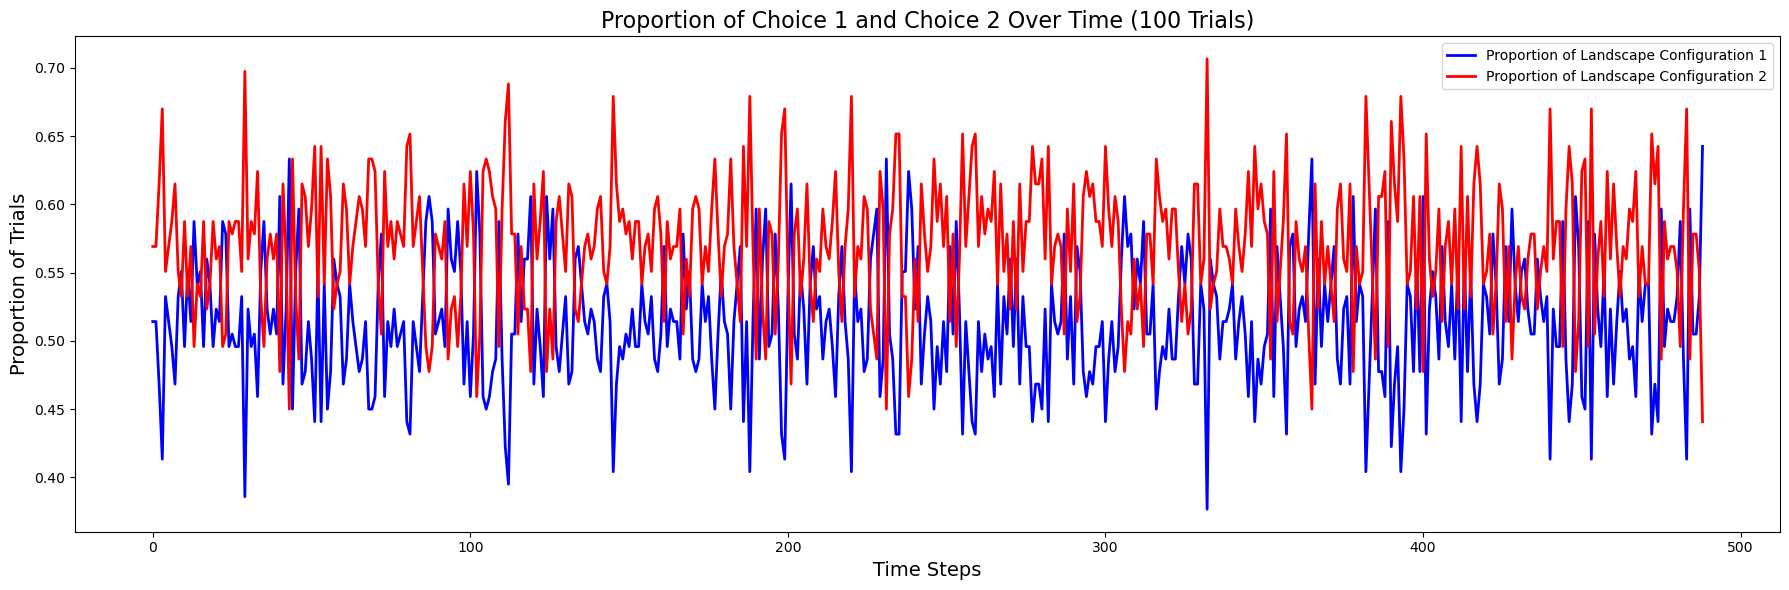

In [117]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate the proportion of two choices (Choice 1 and Choice 2) at each time step
def calculate_choice_frequencies(data):
    # Number of trials and time steps
    num_trials = 100
    num_time_steps =489
    # Initializenp.arrays to store the proportions of Choice 1 and Choice 2
    proportion_choice_1 = np.zeros(num_time_steps)
    proportion_choice_2 = np.zeros(num_time_steps)
    distinct_neighbourhoods = get_distinct_neighbourhoods(data[1])

    std_choice_1 = np.zeros(num_time_steps)
    std_choice_2 = np.zeros(num_time_steps)

    # For each time step, calculate the proportion of Choice 1 and Choice 2
    for t in range(num_time_steps):
        choices_at_t = data[:, t]  # Get all choices at time step t (for all trials)
        proportion_choice_1[t] = np.mean(choices_at_t == distinct_neighbourhoods[0])  # Proportion of Choice 1 (e.g., 0)
        proportion_choice_2[t] = np.mean(choices_at_t == distinct_neighbourhoods[1])  # Proportion of Choice 2 (e.g., 1)

        std_choice_1[t] = np.std(choices_at_t == distinct_neighbourhoods[0])
        std_choice_2[t] = np.std(choices_at_t == distinct_neighbourhoods[1])
    
    return proportion_choice_1, proportion_choice_2, std_choice_1, std_choice_2

# Example data (replace this with your actual outputs_R3_c2 data)
# Assuming outputs_R3_c2 is a 2Dnp.array where rows are trials, columns are time steps
# For example, 100 trials, 500 time steps, with 0 and 1 representing two different choices
data =np.array(outputs_R3_c2)
# 1. Calculate the proportions of Choice 1 and Choice 2 at each time step
proportion_choice_1, proportion_choice_2, std_choice_1, std_choice_2 = calculate_choice_frequencies(data)


# 2. Plot the results
plt.figure(figsize=(18, 6))

# Plot the proportion of Choice 1 and Choice 2
plt.plot(proportion_choice_1, label='Proportion of Landscape Configuration 1', color='blue', linewidth=2)
plt.plot(proportion_choice_2, label='Proportion of Landscape Configuration 2', color='red', linewidth=2)

#plt.fill_between(range(489), proportion_choice_1 - std_choice_1, proportion_choice_1 + std_choice_1, color='blue', alpha=0.2)
#plt.fill_between(range(489), proportion_choice_2 - std_choice_2, proportion_choice_2 + std_choice_2, color='red', alpha=0.2)

# Add labels and title
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Proportion of Trials', fontsize=14)
plt.title('Proportion of Choice 1 and Choice 2 Over Time (100 Trials)', fontsize=16)

# Add a legend
plt.legend(loc='best')
#
# Display the plot
plt.tight_layout()
plt.savefig('Aggregate_landscape_configuration_mimic_disorder_12_q_inhomo_v1.png')
plt.show()


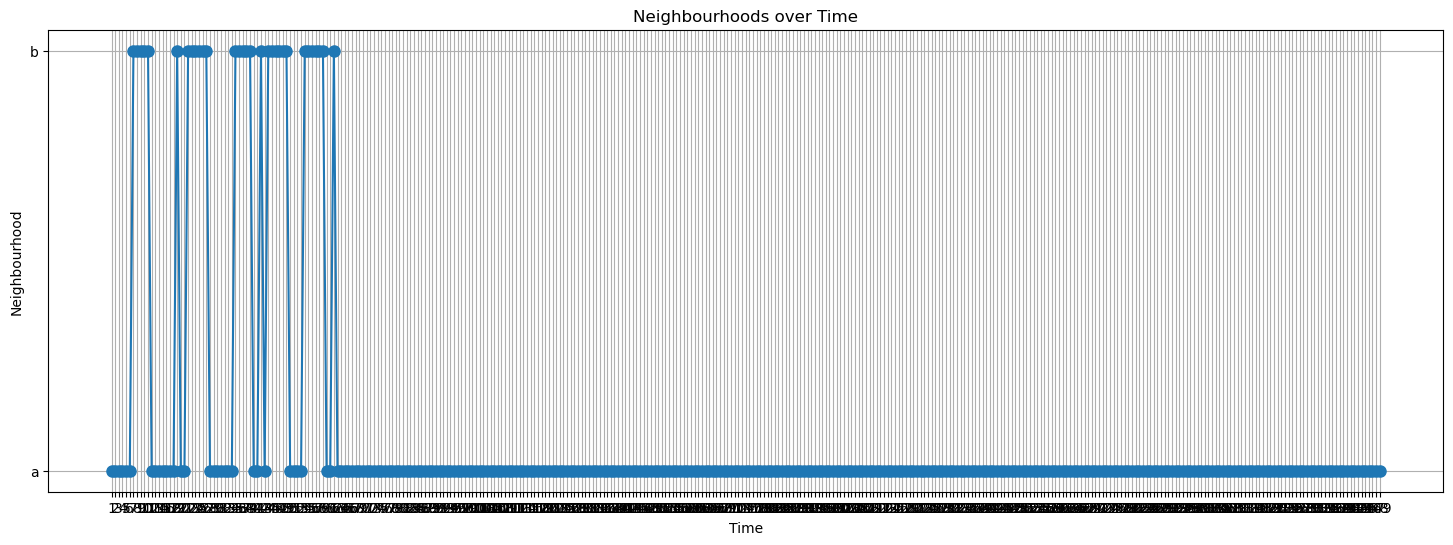

Distinct Neighbourhoods:
a: [[ 0  1]
 [10 11]
 [ 2  3]
 [ 6  7]
 [ 4  5]
 [ 8  9]]
b: [[ 9 10]
 [ 1  2]
 [ 3  4]
 [ 0 11]
 [ 5  6]
 [ 7  8]]


In [79]:
data=outputs_R3_c2_2[13][0:349]
# Get the distinct neighbourhoods
distinct_neighbourhoods = get_distinct_neighbourhoods(data)

# Track when each neighbourhood appears
time_steps = find_neighbourhood_appearances(data, distinct_neighbourhoods)

# Separate out the time and labels for plotting
times = [t for t, label in time_steps]
labels = [label for t, label in time_steps]

# Plotting
plt.figure(figsize=(18, 6))
plt.plot(times, labels, marker='o', linestyle='-', markersize=8)

# Customize the plot
plt.xticks(times)  # Show time steps on x-axis
plt.yticks(list(set(labels)))  # Show neighbourhood labels (a, b, c, ...) on y-axis
plt.xlabel('Time')
plt.ylabel('Neighbourhood')
plt.title('Neighbourhoods over Time')
plt.grid(True)

# Show the plot
plt.show()

# Print the distinct neighbourhoods
print("Distinct Neighbourhoods:")
for i, neighbourhood in enumerate(distinct_neighbourhoods):
    print(f"{chr(97 + i)}: {neighbourhood}")

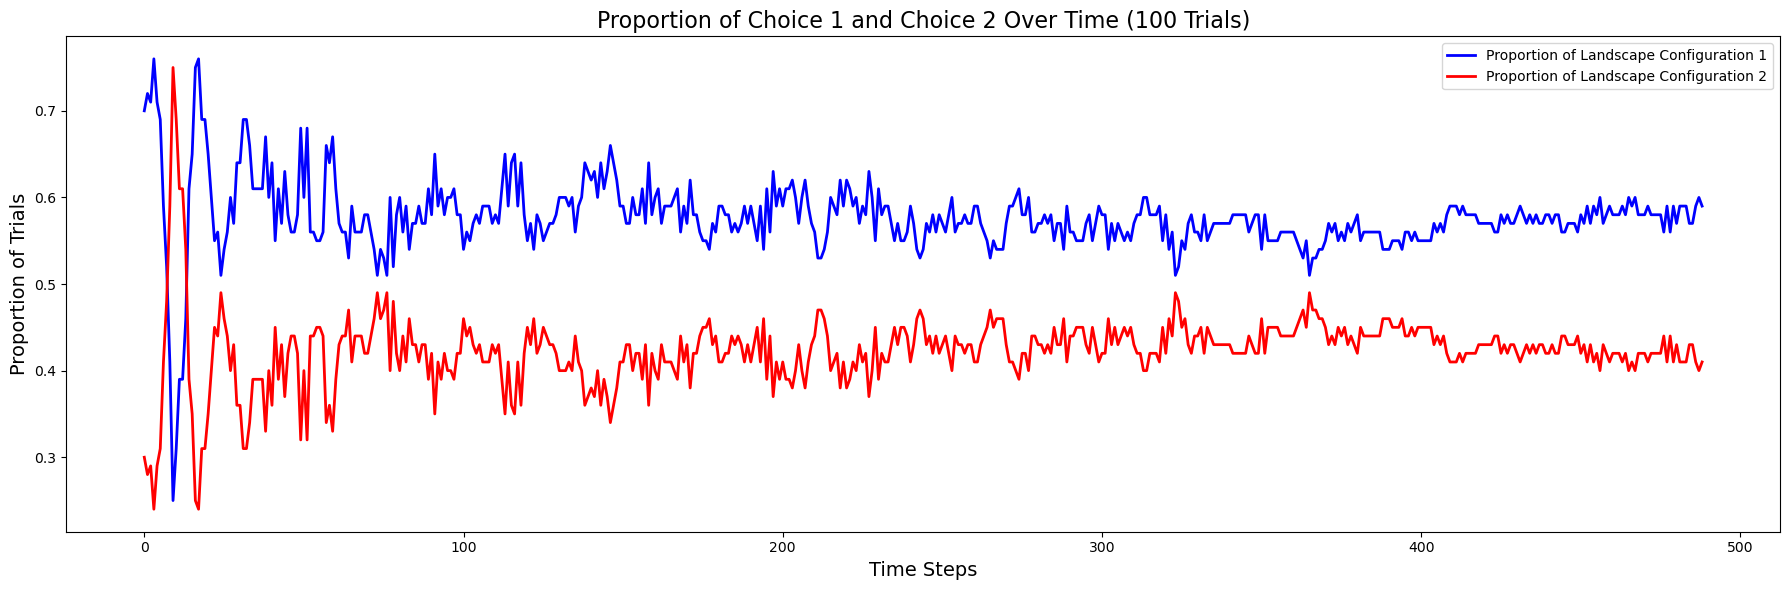

In [116]:
data =np.array(outputs_R3_c2_2)
# 1. Calculate the proportions of Choice 1 and Choice 2 at each time step
proportion_choice_1, proportion_choice_2, std_choice_1, std_choice_2 = calculate_choice_frequencies(data)


# 2. Plot the results
plt.figure(figsize=(18, 6))

# Plot the proportion of Choice 1 and Choice 2
plt.plot(proportion_choice_1, label='Proportion of Landscape Configuration 1', color='blue', linewidth=2)
plt.plot(proportion_choice_2, label='Proportion of Landscape Configuration 2', color='red', linewidth=2)

#plt.fill_between(range(489), proportion_choice_1 - std_choice_1, proportion_choice_1 + std_choice_1, color='blue', alpha=0.2)
#plt.fill_between(range(489), proportion_choice_2 - std_choice_2, proportion_choice_2 + std_choice_2, color='red', alpha=0.2)


# Add labels and title
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Proportion of Trials', fontsize=14)
plt.title('Proportion of Choice 1 and Choice 2 Over Time (100 Trials)', fontsize=16)

# Add a legend
plt.legend(loc='best')
#
# Display the plot
plt.tight_layout()
plt.savefig('Aggregate_landscape_configuration_mimic_update_rule_12_q_inhomo_v1.png')
plt.show()

In [18]:
def compute_ensemble_average(dataset_for_one_rule):
    """
    Compute the ensemble average adjacency matrix from a list of datasets.
    """
    # Initialize adj_matrix_sum to None to indicate it's uninitialized
    adj_matrix_sum = None
    
    # Loop over all datasets and compute the adjacency matrix for each
    for data in dataset_for_one_rule:
        # Flatten the dataset into a list of tuples representing pairs
        edges = [tuple(sorted(pair)) for sublist in data for pair in sublist]
        
        # Count the number of times each node pair appears
        edge_weights = Counter(edges)
        #print(f'edgew:{edge_weights}')

        # Create a graph
        G = nx.Graph()

        # Add edges along with their weights
        for edge, weight in edge_weights.items():
            G.add_edge(edge[0], edge[1], weight=weight/len(data))

        # Get the edge weights
        weights = np.array([G[u][v]['weight'] for u, v in G.edges()])

        # Calculate the adjacency matrix for this dataset
        n_nodes = max(max(edge) for edge in edges) + 1
        adj_matrix = np.zeros((n_nodes, n_nodes))

        for edge, weight in edge_weights.items():
            adj_matrix[edge[0], edge[1]] = weight/len(data)
            adj_matrix[edge[1], edge[0]] = weight/len(data)
            
        # Check the row sums before averaging
        row_sums = adj_matrix.sum(axis=1)
        #print(f"RowS: {row_sums}")
        adj_matrix = np.round(adj_matrix, 2)
        #print(f"Adj: {adj_matrix}")

        # Initialize adj_matrix_sum on the first iteration
        if adj_matrix_sum is None:
            adj_matrix_sum = np.zeros_like(adj_matrix)
        
        # Accumulate the adjacency matrices
        adj_matrix_sum += adj_matrix
    ensemble_avg_matrix=adj_matrix_sum / len(dataset_for_one_rule)
    ensemble_avg_matrix = np.round(ensemble_avg_matrix, 2)
    # Compute the ensemble average
    return ensemble_avg_matrix

In [19]:
def visualize_network(adj_matrix, ax, title, pos, cmap):
    """
    Visualizes a network based on the provided adjacency matrix.
    """
    # Create a graph
    G = nx.from_numpy_array(adj_matrix)  # Use from_numpy_array instead of from_numpy_matrix

    # Normalize the weights for color mapping
    weights = np.array([G[u][v]['weight'] for u, v in G.edges()])
    norm = plt.Normalize(vmin=0, vmax=1)

    # Map edge weights to colors using the given colormap
    edge_colors = [cmap(norm(w)) for w in weights]

    # Scale edge thickness according to the weight (here using width factor for better visibility)
    #min_width = 0.5  # Minimum edge width (for visualization)
    #max_width = 5.0  # Maximum edge width (for visualization)
    #edge_widths = min_width + (weights - np.min(weights)) / (np.max(weights) - np.min(weights)) * (max_width - min_width)

    # Draw the graph with node labels
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500,
            edge_color=edge_colors, width=3, ax=ax)

    # Draw edge labels to show weights
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)}, ax=ax)

    # Add a color bar to show the weight scale
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    #plt.colorbar(sm, ax=ax, label="Edge weight")

    # Add a title to each subplot
    ax.set_title(title,fontsize=14)

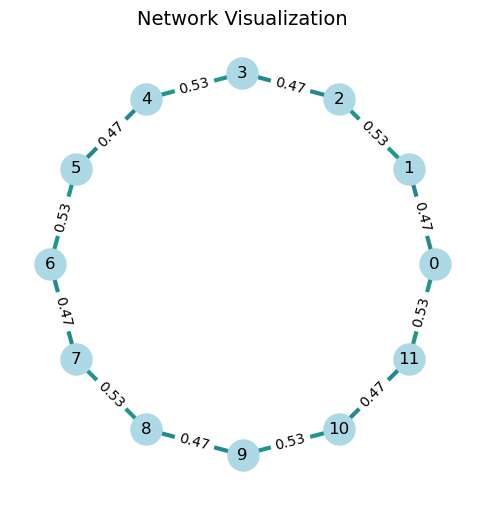

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Define a colormap and positions for nodes
cmap = cm.viridis
pos = nx.circular_layout(nx.from_numpy_array(compute_ensemble_average(outputs_R3_c2)))

# Call the visualize function
visualize_network(compute_ensemble_average(outputs_R3_c2), ax, "Network Visualization", pos, cmap)

# Show the plot
plt.show()


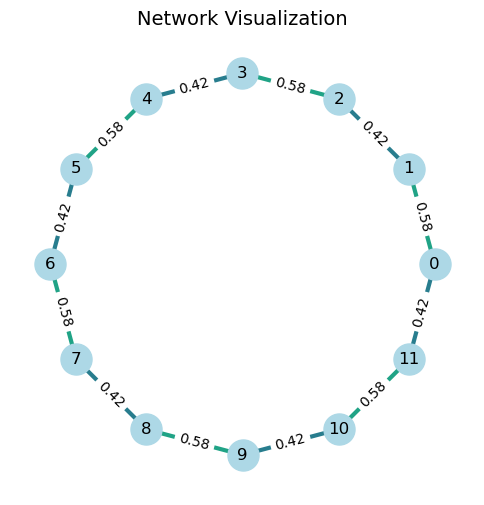

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Define a colormap and positions for nodes
cmap = cm.viridis
pos = nx.circular_layout(nx.from_numpy_array(compute_ensemble_average(outputs_R3_c2_2)))

# Call the visualize function
visualize_network(compute_ensemble_average(outputs_R3_c2_2), ax, "Network Visualization", pos, cmap)

# Show the plot
plt.show()

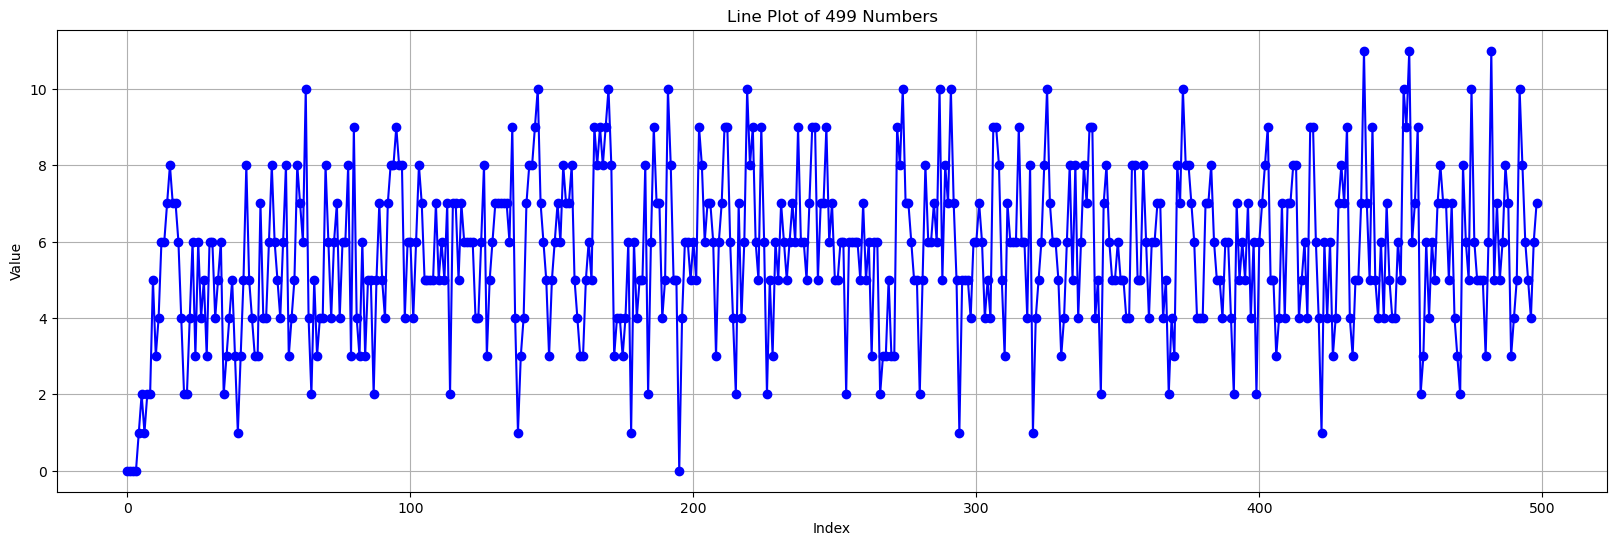

In [38]:
vmin = 0  # Replace with your desired minimum value
vmax = 8  # Replace with your desired maximum value
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
datas=[ens_avg_change_in_ext_work_mimic_disorder_c2]

binary_datas=[]
for data in datas:
    change_per_timestep=[]
    for data_timestep in data:
        data_timestep_peq_q=[]
        for change_q_index in data_timestep:
            if change_q_index<0:
                change_q_index=0
            elif change_q_index>0:
                change_q_index=1
            data_timestep_peq_q.append(change_q_index)
        change_per_timestep.append(data_timestep_peq_q)
    binary_datas.append(change_per_timestep)

for data in binary_datas:

    data = np.sum(data, axis=1)
    # Create a line plot
    plt.figure(figsize=(20, 6))
    plt.plot(data, marker='o', linestyle='-', color='b')  # Plot as a line with markers
    plt.title("Line Plot of 499 Numbers")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

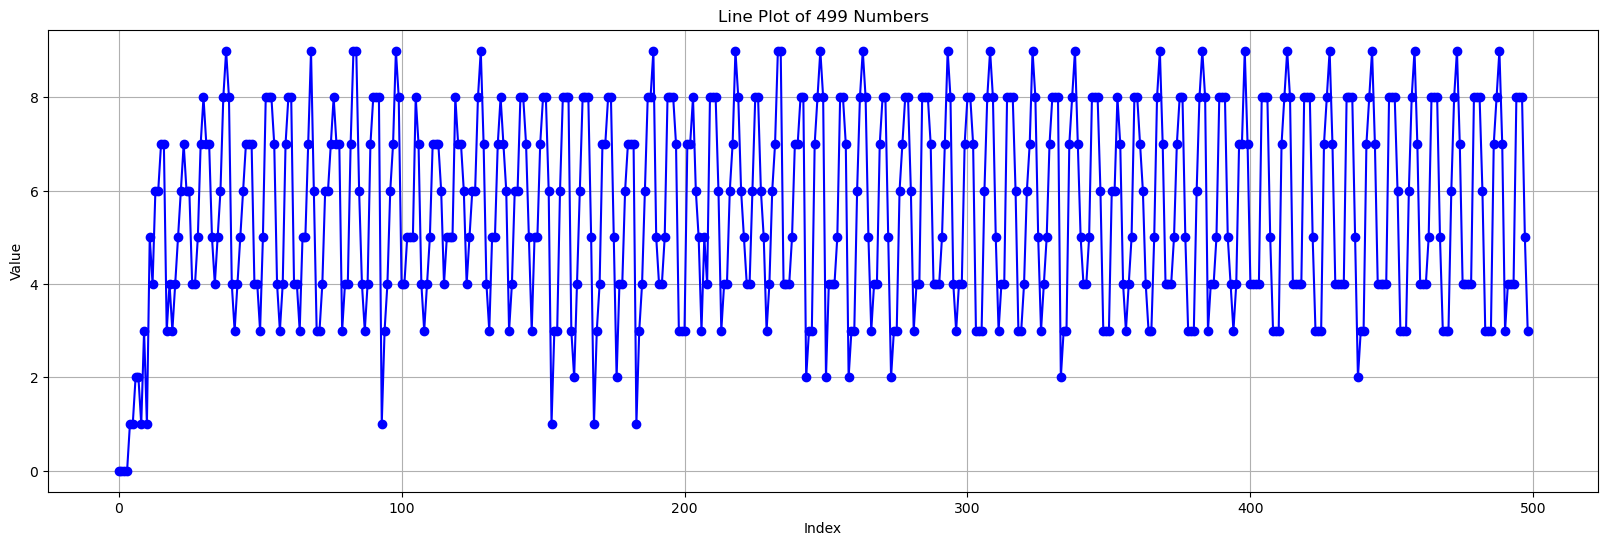

In [75]:
vmin = 0  # Replace with your desired minimum value
vmax = 8  # Replace with your desired maximum value
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
datas=[ens_avg_change_in_ext_work_mimic_disorder_c2_2]

binary_datas=[]
for data in datas:
    change_per_timestep=[]
    for data_timestep in data:
        data_timestep_peq_q=[]
        for change_q_index in data_timestep:
            if change_q_index<0:
                change_q_index=0
            elif change_q_index>0:
                change_q_index=1
            data_timestep_peq_q.append(change_q_index)
        change_per_timestep.append(data_timestep_peq_q)
    binary_datas.append(change_per_timestep)

for data in binary_datas:

    data = np.sum(data, axis=1)
    # Create a line plot
    plt.figure(figsize=(20, 6))
    plt.plot(data, marker='o', linestyle='-', color='b')  # Plot as a line with markers
    plt.title("Line Plot of 499 Numbers")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()